In [1]:
import csv
import string
import os
import json
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import defaultdict
from langdetect import detect
from wordcloud import WordCloud
from nltk.corpus import stopwords



#label font
font = {'family' : 'sans-serif',
        # 'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#color palette
plt.style.use("seaborn-v0_8-colorblind")

#figure size
default_figsize = (10,4)
matplotlib.rcParams["figure.figsize"] = default_figsize

/tmp/ipykernel_367718/2779835890.py:26: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_data['week'] = filtered_data['createdAt'].dt.to_period('W')


<Figure size 1200x600 with 0 Axes>

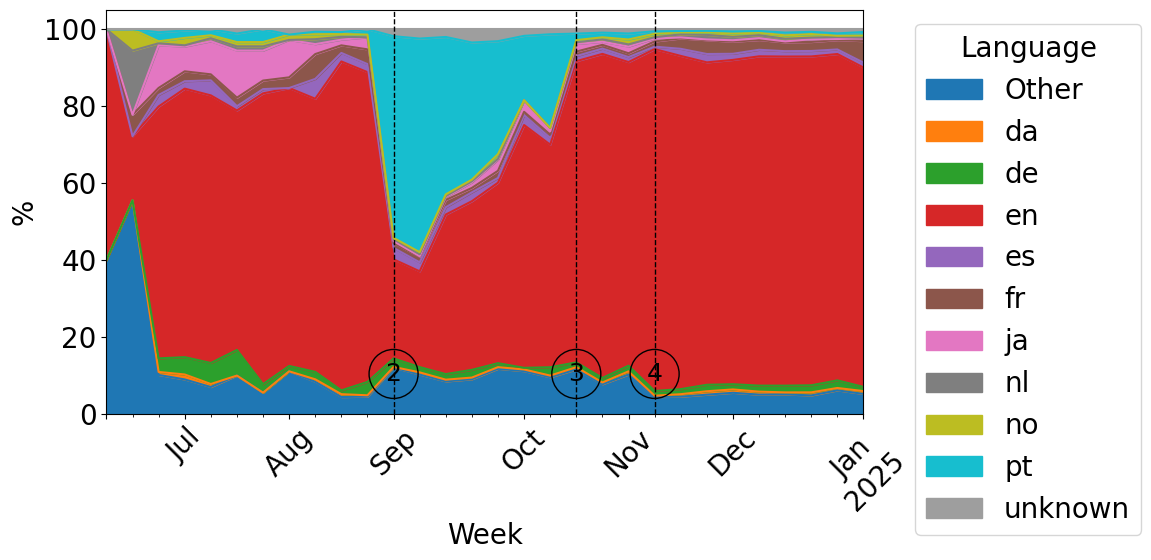

Total Languages: 51


In [2]:
from langdetect import detect, LangDetectException
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '../data/starter_packs/starterpacks_newer.csv'
data = pd.read_csv(file_path)

data['createdAt'] = pd.to_datetime(data['createdAt'], errors='coerce')
data = data.dropna(subset=['createdAt'])
data['description'] = data['description'].fillna('').astype(str)

def safe_detect(text):
    try:
        if not text.strip():
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"

filtered_data = data[data['description'].str.strip() != ""].copy()
filtered_data['language'] = filtered_data['description'].apply(safe_detect)
filtered_data['createdAt'] = pd.to_datetime(filtered_data['createdAt'], errors='coerce')
filtered_data = filtered_data.dropna(subset=['createdAt'])

filtered_data['week'] = filtered_data['createdAt'].dt.to_period('W')

language_counts = filtered_data['language'].value_counts()
total_languages = len(language_counts)

top_languages = language_counts.nlargest(10).index
filtered_data['language_grouped'] = filtered_data['language'].apply(
    lambda lang: lang if lang in top_languages else "Other"
)

language_counts_over_time = (
    filtered_data.groupby(['week', 'language_grouped'])
    .size()
    .unstack(fill_value=0)
)

percentages_over_time = language_counts_over_time.div(language_counts_over_time.sum(axis=1), axis=0) * 100

important_dates = {
    "Twitter ban in Brazil (2)": "2024-08-30",
    "Twitter change to block visibility (3)": "2024-10-17",
    "US elections (4)": "2024-11-05",
}
important_dates = {label: pd.to_datetime(date) for label, date in important_dates.items()}

original_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#9e9e9e'
]

plt.rc('font', size=20)

plt.figure(figsize=(12, 6))
percentages_over_time.plot(
    kind='area',
    stacked=True,
    figsize=(12, 6),
    color=original_colors
)

for label, date in important_dates.items():
    plt.axvline(x=date, color='black', linestyle='--', linewidth=1, alpha=1)
    plt.annotate(
        text=label.split(" ")[-1].strip("()"),
        xy=(date, 5),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        fontsize=18,
        color='black',
        bbox=dict(
            boxstyle='circle',
            facecolor='none',
            edgecolor='black',
            pad=0.5
        )
    )

plt.xlabel('Week', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.xticks(rotation=45)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.tight_layout()
plt.show()

print(f"Total Languages: {total_languages}")

In [ ]:
import csv
from textblob import TextBlob
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

def perform_sentiment_analysis_and_extract_negatives(input_file, output_file):
    sentiment_counts = {"Positive": 0, "Neutral": 0, "Negative": 0}
    sentiment_over_time = []

    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8', newline='') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            try:
                post_text = row.get("post_text", "")
                post_created_at = row.get("post_created_at", "")
                
                blob = TextBlob(post_text)
                sentiment_polarity = blob.sentiment.polarity
                
                if sentiment_polarity > 0.1:
                    sentiment = "Positive"
                    sentiment_counts["Positive"] += 1
                elif sentiment_polarity < -0.1:
                    sentiment = "Negative"
                    sentiment_counts["Negative"] += 1
                    writer.writerow(row)  # Write negative posts to output file
                else:
                    sentiment = "Neutral"
                    sentiment_counts["Neutral"] += 1
                
                sentiment_over_time.append({
                    "date": post_created_at,
                    "sentiment": sentiment
                })

            except Exception as e:
                print(f"Error processing row: {e}")
                continue

    return sentiment_counts, sentiment_over_time

# Function to plot sentiment over time
def plot_sentiment_over_time(sentiment_over_time):
    # Convert to DataFrame
    df = pd.DataFrame(sentiment_over_time)

    try:
        df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')  # Convert to datetime, enforce UTC
        print(df['date'].head())  # Debug: Check parsed dates
    except Exception as e:
        print(f"Error parsing dates: {e}")
        return

    df = df[df['date'] >= pd.Timestamp('2024-06-26', tz='UTC')]

    df = df.dropna(subset=['date'])
    print(df.dtypes)  # Debug: Confirm 'date' is datetime64

    try:
        sentiment_trend = df.groupby([df['date'].dt.date, 'sentiment']).size().unstack(fill_value=0)
    except Exception as e:
        print(f"Error during grouping: {e}")
        return

    plt.figure(figsize=(12, 6))
    for sentiment in sentiment_trend.columns:
        plt.plot(sentiment_trend.index, sentiment_trend[sentiment], label=sentiment)

    # plt.title('Sentiment Analysis Over Time (After 2022)')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')
    plt.legend()
    plt.grid(True)
    plt.show()    

input_csv_file = "../data/starter_packs/starter_packs/starter_pack_mentions_in_posts.csv"
output_csv_file = "../../output_and_test_data/starter_packs/negative_posts.csv"

sentiment_counts, sentiment_over_time = perform_sentiment_analysis_and_extract_negatives(input_csv_file, output_csv_file)

plot_sentiment_over_time(sentiment_over_time)

/tmp/ipykernel_159718/3074402598.py:40: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sentiment_df['week'] = sentiment_df['date'].dt.to_period('W').dt.start_time  # Convert to weekly bins


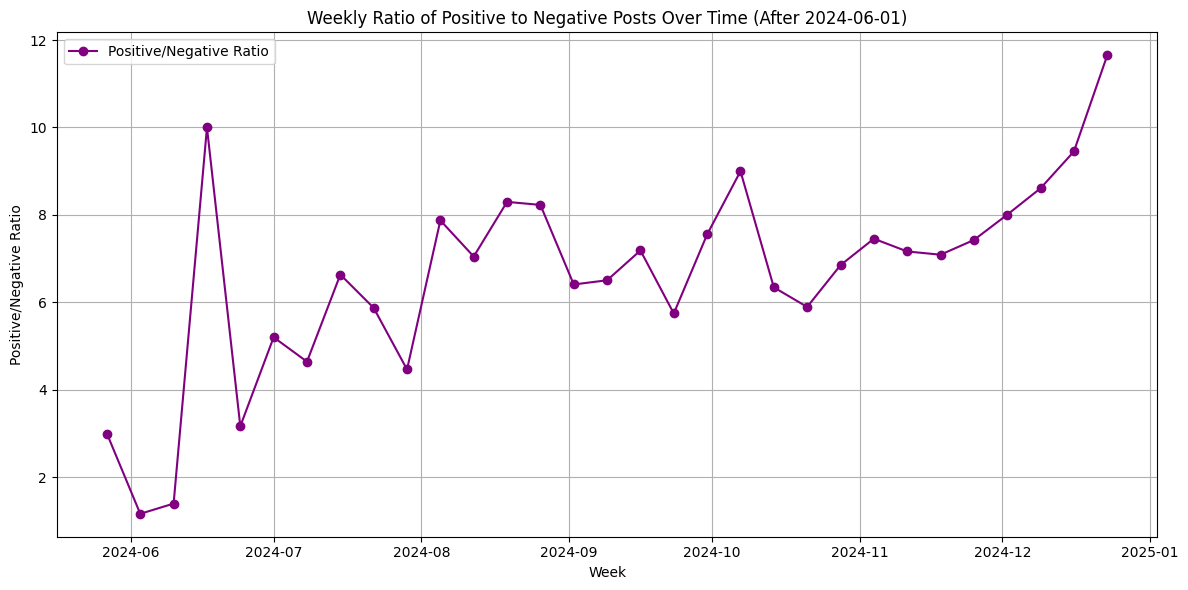

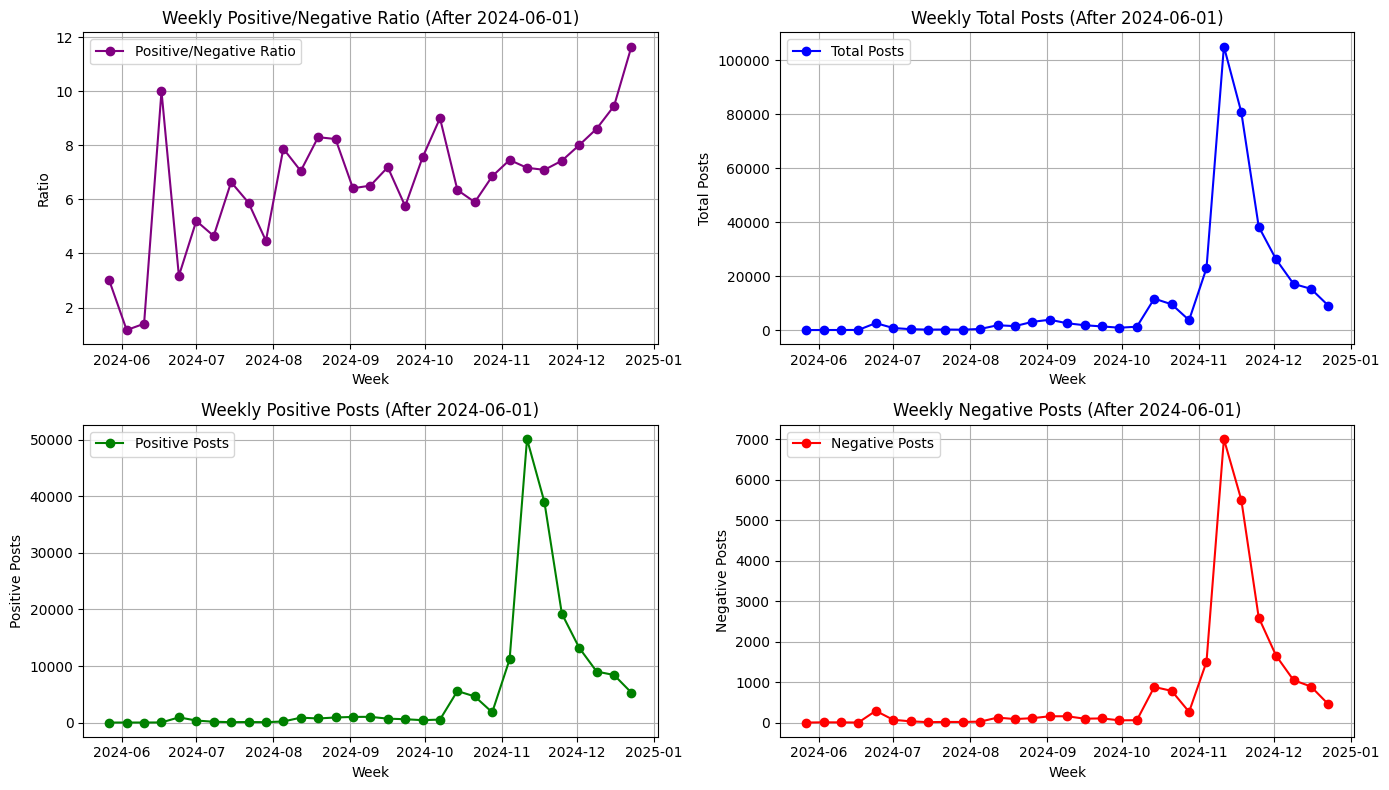

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

mentions_file_path= "../data/post_containing_mention_of_starter_packs/starter_pack_mentions_in_posts.csv"

mentions_data = pd.read_csv(mentions_file_path)

def perform_sentiment_analysis(mentions_data):
    sentiment_over_time = []
    for _, row in mentions_data.iterrows():
        post_text = row.get("post_text", "")
        post_created_at = row.get("post_created_at", "")
        
        blob = TextBlob(post_text)
        sentiment_polarity = blob.sentiment.polarity
        
        if sentiment_polarity > 0.1:
            sentiment = "Positive"
        elif sentiment_polarity < -0.1:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"
        
        sentiment_over_time.append({
            "date": post_created_at,
            "sentiment": sentiment
        })
    
    return sentiment_over_time

sentiment_over_time = perform_sentiment_analysis(mentions_data)

sentiment_df = pd.DataFrame(sentiment_over_time)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], utc=True, errors='coerce')
sentiment_df = sentiment_df.dropna(subset=['date'])
start_date = pd.Timestamp('2024-06-01', tz='UTC')
sentiment_df = sentiment_df[sentiment_df['date'] >= start_date]

sentiment_df['week'] = sentiment_df['date'].dt.to_period('W').dt.start_time  # Convert to weekly bins
weekly_sentiment = sentiment_df.groupby(['week', 'sentiment']).size().unstack(fill_value=0)

# ratio of positive to negative posts
weekly_sentiment['positive_negative_ratio'] = weekly_sentiment['Positive'] / weekly_sentiment['Negative']

plt.figure(figsize=(12, 6))
plt.plot(weekly_sentiment.index, weekly_sentiment['positive_negative_ratio'], marker='o', label='Positive/Negative Ratio', color='purple')
plt.title('Weekly Ratio of Positive to Negative Posts Over Time (After 2024-06-01)')
plt.xlabel('Week')
plt.ylabel('Positive/Negative Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

weekly_metrics = sentiment_df.groupby('week').agg(
    total_posts=('sentiment', 'size'),  # Total posts per week
    positive_posts=('sentiment', lambda x: (x == 'Positive').sum()),  # Positive posts per week
    negative_posts=('sentiment', lambda x: (x == 'Negative').sum()),  # Negative posts per week
    neutral_posts=('sentiment', lambda x: (x == 'Neutral').sum())  # Neutral posts per week
)

# Calculate positive/negative ratio
weekly_metrics['positive_negative_ratio'] = weekly_metrics['positive_posts'] / weekly_metrics['negative_posts']

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(weekly_metrics.index, weekly_metrics['positive_negative_ratio'], marker='o', label='Positive/Negative Ratio', color='purple')
plt.title('Weekly Positive/Negative Ratio (After 2024-06-01)')
plt.xlabel('Week')
plt.ylabel('Ratio')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(weekly_metrics.index, weekly_metrics['total_posts'], marker='o', label='Total Posts', color='blue')
plt.title('Weekly Total Posts (After 2024-06-01)')
plt.xlabel('Week')
plt.ylabel('Total Posts')
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(weekly_metrics.index, weekly_metrics['positive_posts'], marker='o', label='Positive Posts', color='green')
plt.title('Weekly Positive Posts (After 2024-06-01)')
plt.xlabel('Week')
plt.ylabel('Positive Posts')
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(weekly_metrics.index, weekly_metrics['negative_posts'], marker='o', label='Negative Posts', color='red')
plt.title('Weekly Negative Posts (After 2024-06-01)')
plt.xlabel('Week')
plt.ylabel('Negative Posts')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

/tmp/ipykernel_159718/1334588523.py:50: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sentiment_df['week'] = sentiment_df['date'].dt.to_period('W').dt.start_time  # Convert to weekly bins


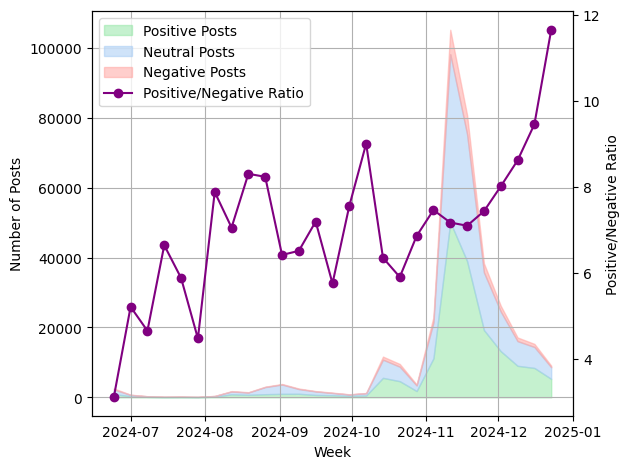

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns

colors = {
    "negative": sns.color_palette("pastel")[3],  # Subtle light red
    "neutral": sns.color_palette("pastel")[0],  # Subtle light blue
    "positive": sns.color_palette("pastel")[2],  # Subtle light green
}

mentions_file_path = "../data/post_containing_mention_of_starter_packs/starter_pack_mentions_in_posts.csv"

mentions_data = pd.read_csv(mentions_file_path)

def perform_sentiment_analysis(mentions_data):
    sentiment_over_time = []
    for _, row in mentions_data.iterrows():
        post_text = row.get("post_text", "")
        post_created_at = row.get("post_created_at", "")
        
        blob = TextBlob(post_text)
        sentiment_polarity = blob.sentiment.polarity
        
        if sentiment_polarity > 0.1:
            sentiment = "Positive"
        elif sentiment_polarity < -0.1:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"
        
        sentiment_over_time.append({
            "date": post_created_at,
            "sentiment": sentiment
        })
    
    return sentiment_over_time

sentiment_over_time = perform_sentiment_analysis(mentions_data)

sentiment_df = pd.DataFrame(sentiment_over_time)

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], utc=True, errors='coerce')

sentiment_df = sentiment_df.dropna(subset=['date'])

start_date = pd.Timestamp('2024-06-26', tz='UTC')
sentiment_df = sentiment_df[sentiment_df['date'] >= start_date]

sentiment_df['week'] = sentiment_df['date'].dt.to_period('W').dt.start_time  # Convert to weekly bins
weekly_sentiment = sentiment_df.groupby(['week', 'sentiment']).size().unstack(fill_value=0)

weekly_sentiment['positive_negative_ratio'] = weekly_sentiment['Positive'] / weekly_sentiment['Negative']

fig, ax1 = plt.subplots()

ax1.fill_between(weekly_sentiment.index, 0, weekly_sentiment['Positive'], 
                 label='Positive Posts', color=colors['positive'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, weekly_sentiment['Positive'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 label='Neutral Posts', color=colors['neutral'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'] + weekly_sentiment['Negative'], 
                 label='Negative Posts', color=colors['negative'], alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(weekly_sentiment.index, weekly_sentiment['positive_negative_ratio'], 
         label='Positive/Negative Ratio', color='purple', marker='o')

ax1.set_xlabel('Week', fontweight='normal')
ax1.set_ylabel('Number of Posts', fontweight='normal')
ax2.set_ylabel('Positive/Negative Ratio', fontweight='normal')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=45)

ax1.grid(True)
plt.tight_layout()
plt.show()

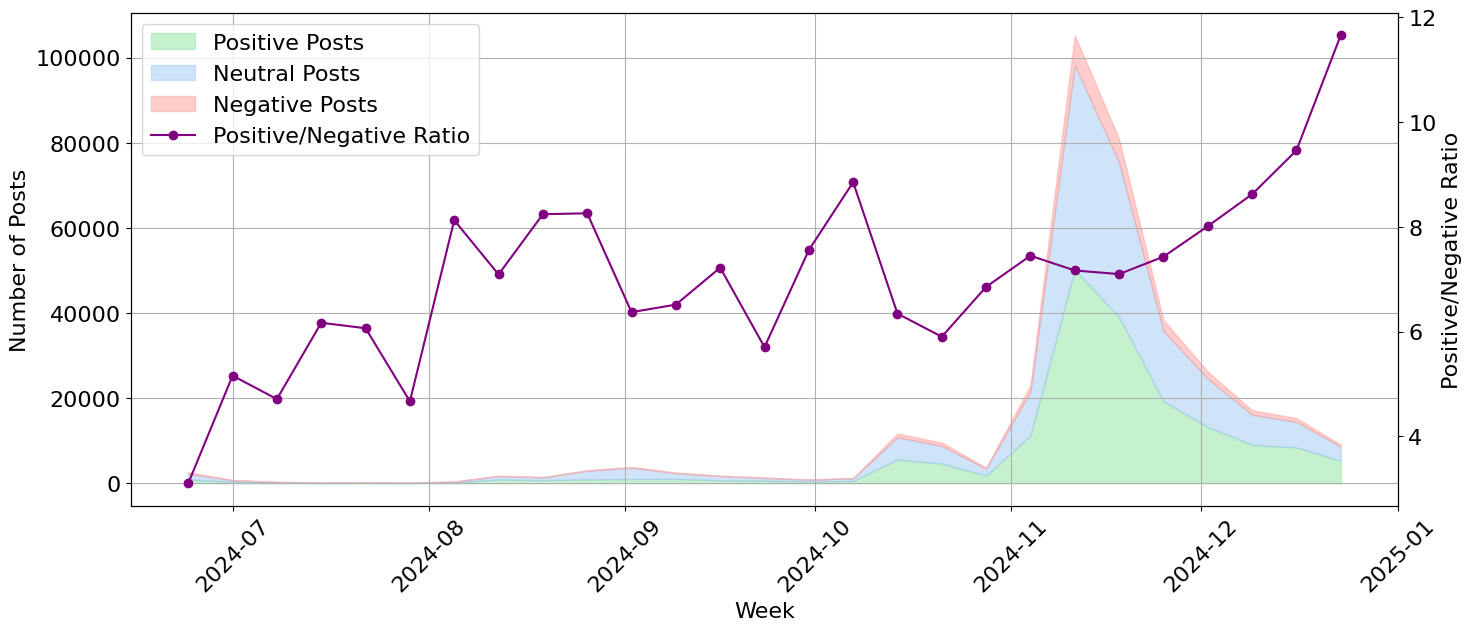

In [ ]:
fig, ax1 = plt.subplots()

ax1.fill_between(weekly_sentiment.index, 0, weekly_sentiment['Positive'], 
                 label='Positive Posts', color=colors['positive'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, weekly_sentiment['Positive'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 label='Neutral Posts', color=colors['neutral'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'] + weekly_sentiment['Negative'], 
                 label='Negative Posts', color=colors['negative'], alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(weekly_sentiment.index, weekly_sentiment['positive_negative_ratio'], 
         label='Positive/Negative Ratio', color='purple', marker='o')

ax1.set_xlabel('Week', fontweight='normal')
ax1.set_ylabel('Number of Posts', fontweight='normal')
ax2.set_ylabel('Positive/Negative Ratio', fontweight='normal')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=45)

ax1.grid(True)

fig.set_size_inches(15, 6)  

plt.tight_layout()
for label in ax1.get_xticklabels():
    label.set_rotation(45)

plt.show()
fig.savefig('figure.pdf', format='pdf', bbox_inches='tight')


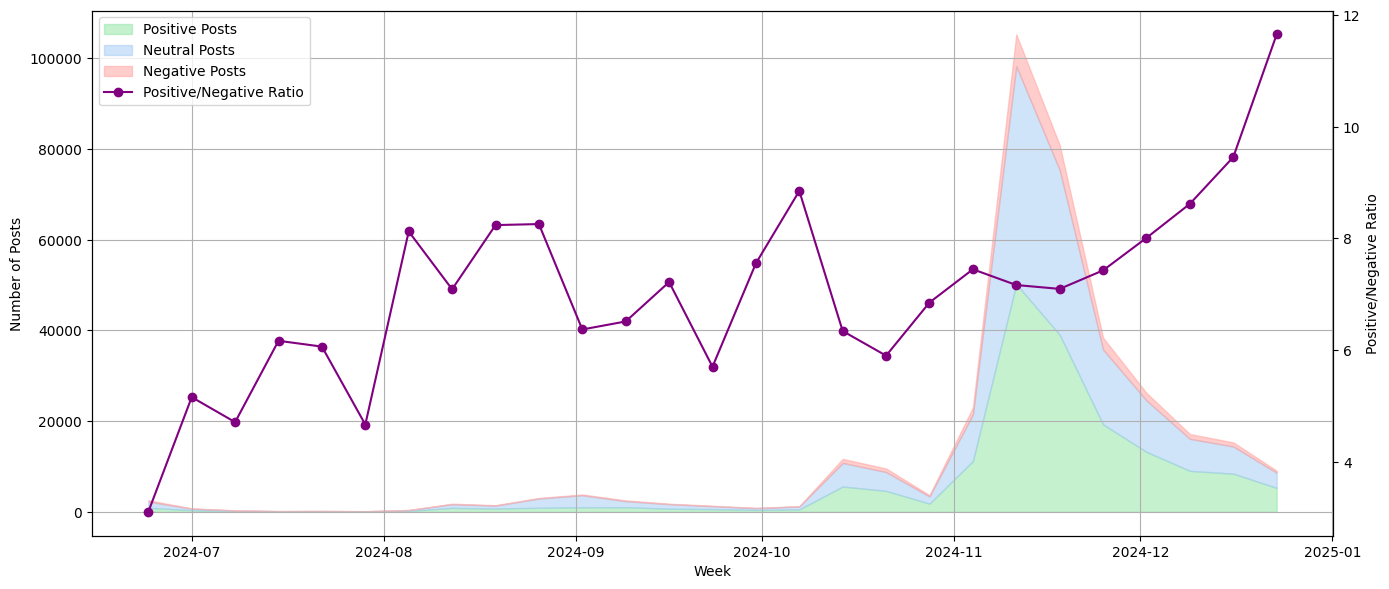

In [3]:
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.fill_between(weekly_sentiment.index, 0, weekly_sentiment['Positive'], 
                 label='Positive Posts', color=colors['positive'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, weekly_sentiment['Positive'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 label='Neutral Posts', color=colors['neutral'], alpha=0.5)
ax1.fill_between(weekly_sentiment.index, 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'], 
                 weekly_sentiment['Positive'] + weekly_sentiment['Neutral'] + weekly_sentiment['Negative'], 
                 label='Negative Posts', color=colors['negative'], alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(weekly_sentiment.index, weekly_sentiment['positive_negative_ratio'], 
         label='Positive/Negative Ratio', color='purple', marker='o')

ax1.set_xlabel('Week', fontweight='normal')
ax1.set_ylabel('Number of Posts', fontweight='normal')
ax2.set_ylabel('Positive/Negative Ratio', fontweight='normal')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

ax1.grid(True)
plt.tight_layout()

plt.show()

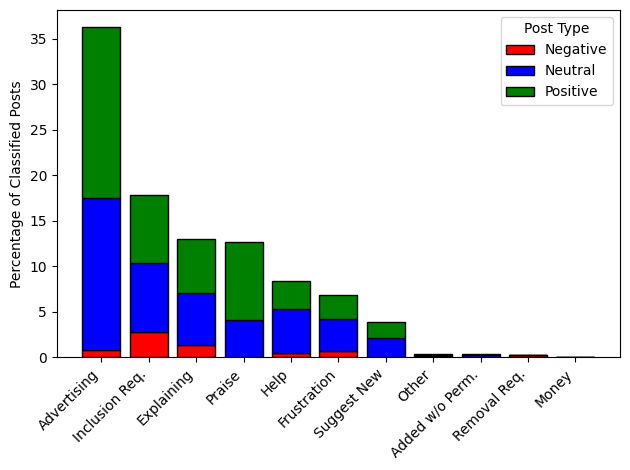

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# File paths for input CSVs
file_paths = {
    "negative": "../../output_and_test_data/starter_packs/classified_negative_posts_hpc.csv",
    "neutral": "../../output_and_test_data/starter_packs/classified_neutral_posts_hpc.csv",
    "positive": "../../output_and_test_data/starter_packs/classified_positive_posts_hpc.csv"
}

negative_mapping = {
    1: "Frustration with the current system",
    2: "Asking for help",
    3: "Asking for money",
    4: "Asking to be removed from a starter pack",
    5: "Added without permission",
    6: "Advertising a starter pack",
    7: "Desire to be included in a starter pack",
    8: "Explaining How the System Works or Reporting Starter Pack Experience",
    9: "Other"
}

neutral_mapping = {
    1: "Praising a Starter Pack or Starter Packs in General",
    2: "Explaining How the System Works or Reporting Starter Pack Experience",
    3: "Desire to Be Added to a Starter Pack",
    4: "Advertising a Starter Pack (including asking for members or inviting others to join)",
    5: "Expressing Frustration with the Current System (e.g., mass follow but zero engagement)",
    6: "Added Without Permission",
    7: "Suggesting Someone Create a New Starter Pack",
    8: "Asking for Help (e.g., understanding how the system works or looking for a specific Starter Pack)",
    9: "Asking for money to include someone in a starter pack",
    10: "Other"
}

positive_mapping = neutral_mapping.copy()

short_category_mapping = {
    "Frustration with the current system": "Frustration",
    "Asking for help": "Help",
    "Asking for money": "Money",
    "Asking to be removed from a starter pack": "Removal Req.",
    "Added without permission": "Added w/o Perm.",
    "Advertising a starter pack": "Advertising",
    "Desire to be included in a starter pack": "Inclusion Req.",
    "Other not covered by the above categories": "Other",
    "Praising a Starter Pack or Starter Packs in General": "Praise",
    "Explaining How the System Works or Reporting Starter Pack Experience": "Explaining",
    "Desire to Be Added to a Starter Pack": "Inclusion Req.",
    "Advertising a Starter Pack (including asking for members or inviting others to join)": "Advertising",
    "Expressing Frustration with the Current System (e.g., mass follow but zero engagement)": "Frustration",
    "Added Without Permission": "Added w/o Perm.",
    "Suggesting Someone Create a New Starter Pack": "Suggest New",
    "Asking for Help (e.g., understanding how the system works or looking for a specific Starter Pack)": "Help",
    "Asking for money to include someone in a starter pack": "Money",
    "Other": "Other"
}

def extract_exact_categories(category_text, mapping):
    numbers = list(map(int, re.findall(r"(?<![\d\$])\b[1-9]\b(?![\d\$])", category_text)))
    if numbers:
        return [mapping.get(num, "Unknown") for num in numbers]
    matched_categories = []
    for num, description in mapping.items():
        if description.lower() in category_text.lower():
            matched_categories.append(description)
    return matched_categories if matched_categories else ["Unknown"]

category_counts = {}

for post_type, file_path in file_paths.items():
    data = pd.read_csv(file_path) 

    mapping = negative_mapping if post_type == "negative" else neutral_mapping

    data['extracted_categories'] = data['category'].apply(
        lambda x: extract_exact_categories(str(x), mapping)
    )

    data['short_categories'] = data['extracted_categories'].apply(
        lambda cats: [short_category_mapping.get(cat, "Unknown") for cat in cats]
    )

    all_short_categories = [cat for sublist in data['short_categories'] for cat in sublist]
    category_counts[post_type] = pd.Series(all_short_categories).value_counts()

for post_type in file_paths.keys():
    if post_type not in category_counts:
        category_counts[post_type] = pd.Series(dtype=float)

combined_counts = pd.DataFrame(category_counts).fillna(0)

total_posts = sum(len(pd.read_csv(file)) for file in file_paths.values())

category_percentages = combined_counts / total_posts * 100

category_percentages['total'] = category_percentages.sum(axis=1)
sorted_category_percentages = category_percentages.sort_values(by='total', ascending=False)

colors = {
    "negative": "red",
    "neutral": "blue",
    "positive": "green"
}

bottom = np.zeros(len(sorted_category_percentages.index))
for post_type in sorted_category_percentages.columns[:-1]:  
    plt.bar(
        sorted_category_percentages.index,
        sorted_category_percentages[post_type],
        label=post_type.capitalize(),
        bottom=bottom,
        color=colors[post_type],
        edgecolor='black'
    )
    bottom += sorted_category_percentages[post_type].values

plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Classified Posts')
plt.legend(title='Post Type')
plt.tight_layout()
plt.show()

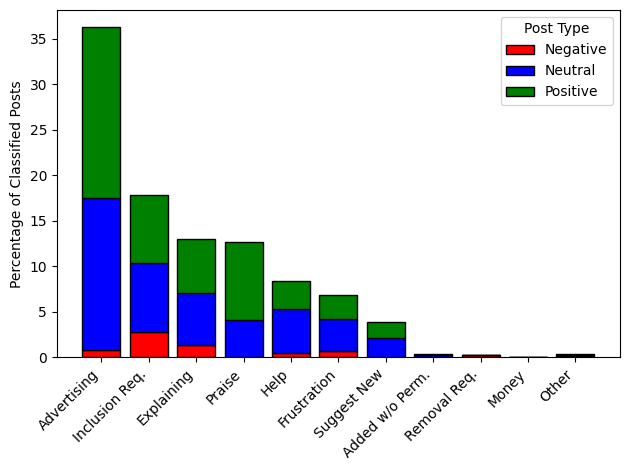

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

file_paths = {
    "negative": "../../output_and_test_data/starter_packs/classified_negative_posts_hpc.csv",
    "neutral": "../../output_and_test_data/starter_packs/classified_neutral_posts_hpc.csv",
    "positive": "../../output_and_test_data/starter_packs/classified_positive_posts_hpc.csv"
}

negative_mapping = {
    1: "Frustration with the current system",
    2: "Asking for help",
    3: "Asking for money",
    4: "Asking to be removed from a starter pack",
    5: "Added without permission",
    6: "Advertising a starter pack",
    7: "Desire to be included in a starter pack",
    8: "Explaining How the System Works or Reporting Starter Pack Experience",
    9: "Other"
}

neutral_mapping = {
    1: "Praising a Starter Pack or Starter Packs in General",
    2: "Explaining How the System Works or Reporting Starter Pack Experience",
    3: "Desire to Be Added to a Starter Pack",
    4: "Advertising a Starter Pack (including asking for members or inviting others to join)",
    5: "Expressing Frustration with the Current System (e.g., mass follow but zero engagement)",
    6: "Added Without Permission",
    7: "Suggesting Someone Create a New Starter Pack",
    8: "Asking for Help (e.g., understanding how the system works or looking for a specific Starter Pack)",
    9: "Asking for money to include someone in a starter pack",
    10: "Other"
}

positive_mapping = neutral_mapping.copy()

short_category_mapping = {
    "Frustration with the current system": "Frustration",
    "Asking for help": "Help",
    "Asking for money": "Money",
    "Asking to be removed from a starter pack": "Removal Req.",
    "Added without permission": "Added w/o Perm.",
    "Advertising a starter pack": "Advertising",
    "Desire to be included in a starter pack": "Inclusion Req.",
    "Praising a Starter Pack or Starter Packs in General": "Praise",
    "Explaining How the System Works or Reporting Starter Pack Experience": "Explaining",
    "Desire to Be Added to a Starter Pack": "Inclusion Req.",
    "Advertising a Starter Pack (including asking for members or inviting others to join)": "Advertising",
    "Expressing Frustration with the Current System (e.g., mass follow but zero engagement)": "Frustration",
    "Added Without Permission": "Added w/o Perm.",
    "Suggesting Someone Create a New Starter Pack": "Suggest New",
    "Asking for Help (e.g., understanding how the system works or looking for a specific Starter Pack)": "Help",
    "Asking for money to include someone in a starter pack": "Money",
    "Other": "Other",
    "Unknown": "Other"
}

def extract_exact_categories(category_text, mapping):
    category_text = str(category_text) 
    numbers = list(map(int, re.findall(r"(?<![\d\$])\b[1-9]\b(?![\d\$])", category_text)))
    if numbers:
        return [mapping.get(num, "Unknown") for num in numbers]
    matched_categories = []
    for num, description in mapping.items():
        if description.lower() in category_text.lower():
            matched_categories.append(description)
    return matched_categories if matched_categories else ["Unknown"]

category_counts = {}

# Process all posts without sampling
for post_type, file_path in file_paths.items():
    data = pd.read_csv(file_path)

    mapping = negative_mapping if post_type == "negative" else neutral_mapping

    data['extracted_categories'] = data['category'].apply(
        lambda x: extract_exact_categories(x, mapping)
    )

    data['short_categories'] = data['extracted_categories'].apply(
        lambda cats: [short_category_mapping.get(cat, "Unknown") for cat in cats]
    )

    all_short_categories = [cat for sublist in data['short_categories'] for cat in sublist]
    category_counts[post_type] = pd.Series(all_short_categories).value_counts()

for post_type in file_paths.keys():
    if post_type not in category_counts:
        category_counts[post_type] = pd.Series(dtype=float)

combined_counts = pd.DataFrame(category_counts).fillna(0)

total_posts = sum(len(pd.read_csv(file)) for file in file_paths.values())

category_percentages = combined_counts / total_posts * 100

category_percentages['total'] = category_percentages.sum(axis=1)
sorted_category_percentages = category_percentages.sort_values(by='total', ascending=False)

if "Other" in sorted_category_percentages.index:
    other_row = sorted_category_percentages.loc["Other"]
    sorted_category_percentages = sorted_category_percentages.drop("Other")
    sorted_category_percentages.loc["Other"] = other_row

colors = {"negative": "red", "neutral": "blue", "positive": "green"}
bottom = np.zeros(len(sorted_category_percentages.index))

for post_type in sorted_category_percentages.columns[:-1]:  
    plt.bar(
        sorted_category_percentages.index,
        sorted_category_percentages[post_type],
        label=post_type.capitalize(),
        bottom=bottom,
        color=colors[post_type],
        edgecolor='black'
    )
    bottom += sorted_category_percentages[post_type].values

plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Classified Posts')
plt.legend(title='Post Type')
plt.tight_layout()
plt.show()

/home/addr777/miniconda3/envs/h2ogpt_gpu/lib/python3.10/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy.stats import gaussian_kde


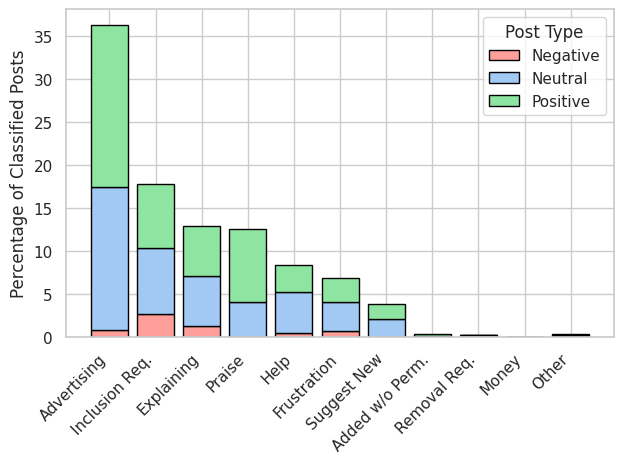

In [3]:
import seaborn as sns

sns.set_theme(style="whitegrid")

colors = {
    "negative": sns.color_palette("pastel")[3],  # Subtle light red
    "neutral": sns.color_palette("pastel")[0],  # Subtle light blue
    "positive": sns.color_palette("pastel")[2],  # Subtle light green
}

bottom = np.zeros(len(sorted_category_percentages.index))
for post_type in sorted_category_percentages.columns[:-1]: 
    plt.bar(
        sorted_category_percentages.index,
        sorted_category_percentages[post_type],
        label=post_type.capitalize(),
        bottom=bottom,
        color=colors[post_type],
        edgecolor='black'
    )
    bottom += sorted_category_percentages[post_type].values

plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Classified Posts')
# plt.title('Category Distribution Across Post Types (Sorted by Total Percentage)', fontsize=16)
plt.legend(title='Post Type')
plt.tight_layout()
plt.show()

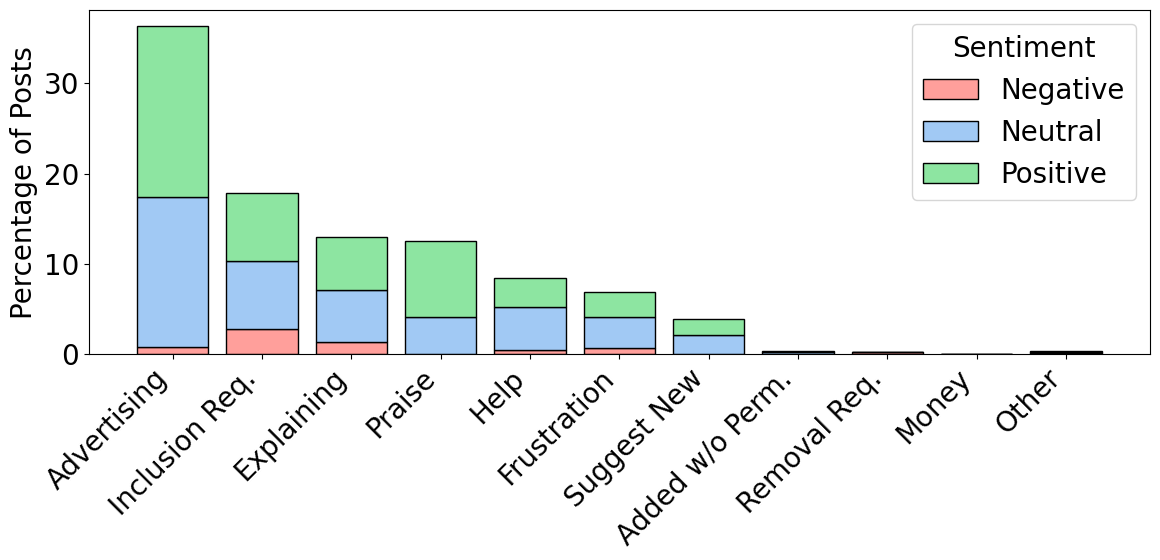

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import seaborn as sns

from difflib import SequenceMatcher
from matplotlib.ticker import PercentFormatter


colors = {
    "negative": sns.color_palette("pastel")[3],  # Subtle light red
    "neutral": sns.color_palette("pastel")[0],  # Subtle light blue
    "positive": sns.color_palette("pastel")[2],  # Subtle light green
}

file_paths = {
    "negative": "../../output_and_test_data/starter_packs/classified_negative_posts_hpc.csv",
    "neutral": "../../output_and_test_data/starter_packs/classified_neutral_posts_hpc.csv",
    "positive": "../../output_and_test_data/starter_packs/classified_positive_posts_hpc.csv"
}

short_category_mapping = {
    "Frustration with the current system": "Frustration",
    "Asking for help": "Help",
    "Asking for money": "Money",
    "Asking to be removed from a starter pack": "Removal Req.",
    "Added without permission": "Added w/o Perm.",
    "Advertising a starter pack": "Advertising",
    "Desire to be included in a starter pack": "Inclusion Req.",
    "Praising a Starter Pack or Starter Packs in General": "Praise",
    "Explaining How the System Works or Reporting Starter Pack Experience": "Explaining",
    "Desire to Be Added to a Starter Pack": "Inclusion Req.",
    "Advertising a Starter Pack (including asking for members or inviting others to join)": "Advertising",
    "Expressing Frustration with the Current System (e.g., mass follow but zero engagement)": "Frustration",
    "Added Without Permission": "Added w/o Perm.",
    "Suggesting Someone Create a New Starter Pack": "Suggest New",
    "Asking for Help (e.g., understanding how the system works or looking for a specific Starter Pack)": "Help",
    "Asking for money to include someone in a starter pack": "Money",
    "Other": "Other",
    "Unknown": "Other"
}

def map_to_short_category(category_text):
    """Robust mapping with exact, partial, and fuzzy matching"""
    category_text = str(category_text).strip().lower()
    
    # 1. Exact/partial match
    for full_desc, short_cat in short_category_mapping.items():
        if full_desc.lower() in category_text:  # Partial match
            return short_cat
    
    # 2. Fuzzy match (for typos/shortened text)
    for full_desc, short_cat in short_category_mapping.items():
        similarity = SequenceMatcher(None, full_desc.lower(), category_text).ratio()
        if similarity > 0.85:  # 85% similarity threshold
            return short_cat
    
    return "Other"

# Process all files
all_data = []
for post_type, file_path in file_paths.items():
    data = pd.read_csv(file_path)
    data['mapped_category'] = data['category'].apply(map_to_short_category)
    data['post_type'] = post_type
    all_data.append(data[['mapped_category', 'post_type']])

# Combine data
df = pd.concat(all_data)
total_posts = len(df)

# Create pivot table (percentages)
pivot_percent = pd.pivot_table(
    df,
    index='mapped_category',
    columns='post_type',
    aggfunc='size',
    fill_value=0
) / total_posts * 100

# Sort by total percentage but force "Other" to end
pivot_percent['total'] = pivot_percent.sum(axis=1)
if 'Other' in pivot_percent.index:
    other_row = pivot_percent.loc['Other']
    pivot_percent = pivot_percent.drop('Other').sort_values('total', ascending=False)
    pivot_percent.loc['Other'] = other_row
else:
    pivot_percent = pivot_percent.sort_values('total', ascending=False)
pivot_percent = pivot_percent.drop(columns='total')

from matplotlib import rcParams
rcParams.update({'font.size': 20})  # Adjust the font size as needed

# Plot
plt.figure(figsize=(12, 6))
bottom = np.zeros(len(pivot_percent.index))

for post_type in ['negative', 'neutral', 'positive']:
    if post_type in pivot_percent.columns:
        plt.bar(
            pivot_percent.index,
            pivot_percent[post_type],
            label=post_type.capitalize(),
            bottom=bottom,
            color=colors[post_type],
            edgecolor='black',
            alpha=1
        )
        bottom += pivot_percent[post_type].values

plt.xticks(rotation=45, ha='right', fontsize=20)  # Adjust x-axis tick font size
plt.yticks(fontsize=20)  # Adjust y-axis tick font size
plt.ylabel('Percentage of Posts', fontsize=20)  # Adjust y-axis label font size
# plt.xlabel('Categories', fontsize=16)  # Add x-axis label and adjust font size
plt.legend(title='Sentiment', fontsize=20, title_fontsize=20)  # Adjust legend font sizes
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import re
import random
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def generate_random_color():
    return f"rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 0.6)"

def enhanced_normalize(text):
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r"\(.*?\)", "", text)  # Remove parentheses
    text = re.sub(r"-.*", "", text).strip()  # Remove text after dash
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    
    # Lemmatization
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized)

def semantic_clustering(texts, threshold=0.7):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(texts)
    
    # Cluster based on cosine similarity
    clustering = AgglomerativeClustering(
        n_clusters=None,
        metric='cosine',
        linkage='average',
        distance_threshold=1-threshold
    )
    clusters = clustering.fit_predict(embeddings)
    
    return clusters

def auto_group_labels(labels, threshold=0.7):
    if len(labels) == 0:
        return {}
    
    clusters = semantic_clustering(labels, threshold)
    
    label_mapping = {}
    cluster_representatives = {}
    
    for cluster_id in np.unique(clusters):
        cluster_labels = np.array(labels)[clusters == cluster_id]
        
        if len(cluster_labels) == 0:
            continue
            
        representative = min(cluster_labels, key=len)
        
        if any("other" in label.lower() for label in cluster_labels):
            representative = "Others"
        
        cluster_representatives[cluster_id] = representative
        
        for label in cluster_labels:
            label_mapping[label] = representative
    
    return label_mapping

file_path = "../../output_and_test_data/starter_packs/classified_starter_packs_hpc.csv"
df = pd.read_csv(file_path)

df["cleaned_starter_pack"] = df["starter_pack_classification"].apply(enhanced_normalize)
df["cleaned_participants"] = df["participants_classification"].apply(enhanced_normalize)

df["cleaned_starter_pack"] = df["cleaned_starter_pack"].replace("", "Others")
df["cleaned_participants"] = df["cleaned_participants"].replace("", "Others")

all_starter_labels = df["cleaned_starter_pack"].unique()
all_participant_labels = df["cleaned_participants"].unique()

starter_mapping = auto_group_labels(all_starter_labels)
participant_mapping = auto_group_labels(all_participant_labels)

df["grouped_starter_pack"] = df["cleaned_starter_pack"].map(starter_mapping)
df["grouped_participants"] = df["cleaned_participants"].map(participant_mapping)

df["grouped_starter_pack"] = df["grouped_starter_pack"].fillna("Others")
df["grouped_participants"] = df["grouped_participants"].fillna("Others")

starter_pack_counts = df["grouped_starter_pack"].value_counts()
participant_counts = df["grouped_participants"].value_counts()

top_n = 15
top_starter_packs = starter_pack_counts.nlargest(top_n).index.tolist()
top_participants = participant_counts.nlargest(top_n).index.tolist()

if "Others" not in top_starter_packs and starter_pack_counts.get("Others", 0) > 0:
    top_starter_packs.append("Others")
if "Others" not in top_participants and participant_counts.get("Others", 0) > 0:
    top_participants.append("Others")

df["grouped_starter_pack"] = df["grouped_starter_pack"].apply(
    lambda x: x if x in top_starter_packs else "Others"
)
df["grouped_participants"] = df["grouped_participants"].apply(
    lambda x: x if x in top_participants else "Others"
)

starter_pack_counts = df["grouped_starter_pack"].value_counts()
participant_counts = df["grouped_participants"].value_counts()

starter_pack_classes = starter_pack_counts.index.tolist()
participant_classes = participant_counts.index.tolist()

starter_pack_class_map = {label: idx for idx, label in enumerate(starter_pack_classes)}
participant_class_map = {
    label: idx + len(starter_pack_classes)
    for idx, label in enumerate(participant_classes)
}

df["source"] = df["grouped_starter_pack"].map(starter_pack_class_map)
df["target"] = df["grouped_participants"].map(participant_class_map)

source_target_counts = (
    df.groupby(["source", "target"])
    .size()
    .reset_index(name="value")
)

all_nodes = starter_pack_classes + participant_classes
labels = all_nodes

node_colors = {label: generate_random_color() for label in all_nodes}
link_colors = [
    node_colors[starter_pack_classes[row["source"]]]
    for _, row in source_target_counts.iterrows()
]

sankey_fig = go.Figure(
    go.Sankey(
        node=dict(
            pad=30,
            thickness=15,
            line=dict(color="black", width=0.5),
            label=labels,
            color=[node_colors[label] for label in labels],
            hovertemplate='<b>%{label}</b><br>Total: %{value}<extra></extra>',
        ),
        link=dict(
            source=source_target_counts["source"],
            target=source_target_counts["target"],
            value=source_target_counts["value"],
            color=link_colors,
            hovertemplate='Source: %{source.label}<br>Target: %{target.label}<br>Count: %{value}<extra></extra>',
        ),
    )
)

sankey_fig.update_layout(
    title_text="Starter Pack to Participant Classification Flow",
    title_font_size=24,
    font_size=14,
    width=1600,
    height=1200,
    margin=dict(l=50, r=50, t=80, b=50),
    hovermode="x unified",
)

sankey_fig.write_image("improved_sankey_diagram.png", scale=2)
sankey_fig.show()

/home/addr777/miniconda3/envs/h2ogpt_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/addr777/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/addr777/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import re
from collections import defaultdict, Counter

file_path = "../data/classified_posts/classified_starter_packs_hpc.csv"
df = pd.read_csv(file_path)

def normalize_classification(text, is_starter_pack=False):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r"-.*", "", text).strip()
    if "n/a" in text or "unknown" in text:
        return ""
    text = re.sub(r"[^\w\s]", "", text)

    singular_to_plural = {"art": "arts"}
    for singular, plural in singular_to_plural.items():
        if singular == text:
            text = plural
            break

    if "anti" in text:
        return "activism"

    if is_starter_pack:
        if any(kw in text for kw in {"social media", "media", "social"}):
            return "generic"
        if "creative" in text or "anime" in text:
            return "art"
        if "news aggregator" in text:
            return "news"
        if "political" in text:
            return "politics"
    else:
        if any(kw in text for kw in {"friend", "individual", "fan", "influencer", "user", "users", "social media", "social circle", "community", "people", "consumers", "learners"}):
            return "generic"
        if "creator" in text or "creative" in text:
            return "artists"
    return text

df["cleaned_starter_pack"] = df["starter_pack_classification"].apply(lambda x: normalize_classification(x, is_starter_pack=True))
df["cleaned_participants"] = df["participants_classification"].apply(normalize_classification)

df = df[(df["cleaned_starter_pack"] != "") & (df["cleaned_participants"] != "")]

df["grouped_starter_pack"] = df["cleaned_starter_pack"]
df["grouped_participants"] = df["cleaned_participants"]

top_20_starter_packs = df["grouped_starter_pack"].value_counts().nlargest(10).index
top_20_participants = df["grouped_participants"].value_counts().nlargest(10).index

df = df[df["grouped_starter_pack"].isin(top_20_starter_packs)]
df = df[df["grouped_participants"].isin(top_20_participants)]

starter_pack_classes = df["grouped_starter_pack"].unique()
participant_classes = df["grouped_participants"].unique()

starter_pack_class_map = {label: idx for idx, label in enumerate(starter_pack_classes)}
participant_class_map = {label: idx + len(starter_pack_classes) for idx, label in enumerate(participant_classes)}

df["source"] = df["grouped_starter_pack"].map(starter_pack_class_map)
df["target"] = df["grouped_participants"].map(participant_class_map)

source_target_counts = (
    df.groupby(["source", "target"])
    .size()
    .reset_index(name="value")
)

min_link_threshold = 100
source_target_counts = source_target_counts[source_target_counts["value"] >= min_link_threshold]

# ➕ Calculate inflow and outflow percentages
total_value = source_target_counts["value"].sum()

# Link-level percentages for hover
link_labels = []
for _, row in source_target_counts.iterrows():
    source_label = list(starter_pack_class_map.keys())[list(starter_pack_class_map.values()).index(row["source"])]
    target_label = list(participant_class_map.keys())[list(participant_class_map.values()).index(row["target"])]
    value = row["value"]
    pct = (value / total_value) * 100
    label = f"{source_label} → {target_label} ({pct:.1f}%)"
    link_labels.append(label)

# ➕ Create new labels with flow summaries
inflow = defaultdict(int)
outflow = defaultdict(int)

for _, row in source_target_counts.iterrows():
    outflow[row["source"]] += row["value"]
    inflow[row["target"]] += row["value"]

labels = []
for i in range(len(starter_pack_class_map)):
    value = outflow[i]
    percent = (value / total_value) * 100
    label = list(starter_pack_class_map.keys())[i]
    labels.append(f"{label} ({percent:.1f}%)")

for i in range(len(participant_class_map)):
    node_index = i + len(starter_pack_class_map)
    value = inflow[node_index]
    percent = (value / total_value) * 100
    label = list(participant_class_map.keys())[i]
    labels.append(f"{label} ({percent:.2f}%)")

# ➕ Use seaborn for color palette
palette = sns.color_palette("husl", len(source_target_counts))
colors = [f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.6)" for r, g, b in palette]

# ➕ Assign dominant link colors to nodes
node_colors = defaultdict(list)
for idx, (source, target, value) in enumerate(source_target_counts.itertuples(index=False, name=None)):
    node_colors[source].append((colors[idx], value))
    node_colors[target].append((colors[idx], value))

def get_dominant_color(pairs):
    scores = defaultdict(float)
    for color, value in pairs:
        scores[color] += value
    return max(scores, key=scores.get)

node_colors_dominant = [get_dominant_color(node_colors[i]) if i in node_colors else "rgba(200,200,200,0.6)" for i in range(len(labels))]

# ➕ Build Sankey diagram
fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=10,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors_dominant
    ),
    link=dict(
        source=source_target_counts["source"],
        target=source_target_counts["target"],
        value=source_target_counts["value"],
        color=colors,
        customdata=link_labels,
        hovertemplate='%{customdata}<extra></extra>'
    )
))

fig.update_layout(
    width=1400,
    height=1000,
    margin=dict(l=10, r=10, t=10, b=10),
    hovermode="x unified",
    font=dict(size=34, color="black"),
)

fig.write_image("sankey_with_percentages.png", scale=3)
fig.show()